## **1. Google Drive**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#cur_dir = "/content/drive/MyDrive/CH2/Notebooks"
#%cd $cur_dir


In [2]:
#%pip install torchview


## **2. Import Libraries**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms as tfs
import math

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu128
Device: cuda


## **3. Config and  Helper Functions**

### 3.1 Config

In [4]:
USE_MASKED_PATCHES = False

In [5]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

if USE_MASKED_PATCHES:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches_masked")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","submission_patches_masked")
else:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")
SUBMISSION_PATCH_MASKS = os.path.join(datasets_path, "preprocessing_results","submission_patches","masks")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Patches output path: {PATCHES_OUT}")
print(f"Submission patches output path: {SUBMISSION_PATCHES_OUT}")
print(f"Submission patch masks path: {SUBMISSION_PATCH_MASKS}")


# Define where your Ground Truth binary masks are stored
# Assuming filenames match: img_001.png -> mask_001.png (or similar)
MASKS_DIR = os.path.join(datasets_path, "preprocessing_results", "train_patches", "masks")

# ImageNet normalization statistics
IMAGENET_MEAN = [float(x) for x in [0.485, 0.456, 0.406]]  # or convert your current values to float
IMAGENET_STD  = [float(x) for x in [0.229, 0.224, 0.225]]



TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ../an2dl2526c2
Train data path: ../an2dl2526c2/train_data
Train labels path: ../an2dl2526c2/train_labels.csv
Test data path: ../an2dl2526c2/test_data
Patches output path: ../an2dl2526c2/preprocessing_results/train_patches
Submission patches output path: ../an2dl2526c2/preprocessing_results/submission_patches
Submission patch masks path: ../an2dl2526c2/preprocessing_results/submission_patches/masks


### 3.2 Helper Functions

In [6]:
def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None, aggregation_method='max_confidence'):
    """Plot all patches of a single sample and the aggregated image prediction (Two-Stream Model)."""
    model.eval()
    
    # 1. Robust Dataset Access
    dataset = loader.dataset
    while hasattr(dataset, 'dataset'): # Unwrap Subsets
        dataset = dataset.dataset
    df = dataset.df
    masks_dir = getattr(dataset, 'masks_location', None)

    # 2. Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)

    # 3. Define Transforms
    # Image: Resize -> ToTensor -> Normalize
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Mask: Resize -> ToTensor (No Normalize)
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # 4. Load Data
    images_tensors = []
    masks_tensors = []
    display_imgs = []
    
    # Stats for denormalization (Display only)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    for _, row in sample_patches.iterrows():
        try:
            # --- A. Image ---
            img_path = row['path']
            img = Image.open(img_path).convert('RGB')
            tensor_img = inference_transform(img)
            images_tensors.append(tensor_img)
            
            # Display image (Denormalize)
            disp_img = torch.clamp(tensor_img * std + mean, 0, 1)
            display_imgs.append(disp_img)
            
            # --- B. Mask ---
            if masks_dir:
                img_filename = os.path.basename(img_path)
                mask_filename = img_filename.replace('img_', 'mask_')
                mask_path = os.path.join(masks_dir, mask_filename)
                
                if os.path.exists(mask_path):
                    mask = Image.open(mask_path).convert('L')
                else:
                    mask = Image.new('L', (224, 224), 0)
            else:
                 mask = Image.new('L', (224, 224), 0)
            
            tensor_mask = mask_transform(mask)
            masks_tensors.append(tensor_mask)

        except Exception as e:
            print(f"Error loading {row['path']}: {e}")
            continue

    if not images_tensors:
        print("No valid images found for this sample.")
        return

    # 5. Batch Inference
    batch_imgs = torch.stack(images_tensors).to(device)
    batch_masks = torch.stack(masks_tensors).to(device)
    
    with torch.no_grad():
        # --- FIX: Pass BOTH pillars ---
        # Model returns ONLY logits for Two-Stream
        logits = model(batch_imgs, batch_masks) 
        probs = torch.softmax(logits, dim=1).cpu()

    # 6. Process Predictions
    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    # --- Aggregation Logic ---
    if aggregation_method == 'max_confidence':
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    elif aggregation_method == 'majority_voting':
        counts = np.bincount(patch_preds, minlength=len(label_encoder.classes_))
        image_pred = counts.argmax()
        image_probs = counts / counts.sum()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

    # Labels
    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    true_label_idx = sample_patches.iloc[0]['label_encoded']
    true_label = label_encoder.inverse_transform([true_label_idx])[0]

    # 7. Plotting
    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img_disp.permute(1,2,0))
        
        lbl = label_encoder.inverse_transform([pred])[0]
        color = 'green' if pred == image_pred else 'red'
        
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9, color='black', backgroundcolor='white')
        ax.axis('off')

    # Aggregated Bar Chart
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'lightgray' for i in range(len(class_names))]
    
    y_pos = np.arange(len(class_names))
    ax_bar.barh(y_pos, image_probs, color=colors)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(class_names)
    ax_bar.invert_yaxis()
    
    ax_bar.set_xlabel('Probability' if aggregation_method == 'max_confidence' else 'Vote Share')
    ax_bar.set_xlim([0,1])
    
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label}\nPred: {image_pred_label} ({image_conf:.2%})\n{aggregation_method}")
    
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')

    plt.tight_layout()
    plt.show()

In [7]:
def get_image_predictions(model, loader, device):
    """
    Aggregates patch-level predictions to image-level for Two-Stream (Pillar) models.
    """
    model.eval()

    # 1. robustly retrieve the underlying dataset (handles torch.utils.data.Subset)
    dataset = loader.dataset
    while hasattr(dataset, 'dataset'):
        dataset = dataset.dataset
        
    df = dataset.df
    
    # Retrieve the specific mask folder from the dataset logic
    # This ensures we look in '.../masks/' regardless of where images are
    masks_dir = getattr(dataset, 'masks_location', None)
    print(f"\nUsing masks from: {masks_dir if masks_dir else 'No masks directory specified, using black masks.'}")
    # 2. Define Transforms
    # Image: Standard normalization
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Mask: Resize + ToTensor only
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    y_true = []
    y_pred = []
    
    sample_ids = df['sample_id'].unique()
    print(f"\nAggregating predictions for {len(sample_ids)} unique images...")

    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches for this image
        sample_patches = df[df['sample_id'] == sample_id]

        # Ground Truth
        true_label = sample_patches.iloc[0]['label_encoded']
        y_true.append(true_label)

        patches_img = []
        patches_mask = []

        for img_path in sample_patches['path']:
            try:
                # --- A. Load Image ---
                img = Image.open(img_path).convert('RGB')
                img = inference_transform(img)
                
                # --- B. Load Mask (Robust Path Construction) ---
                if masks_dir:
                    # Logic: /path/to/masks/ + mask_filename.png
                    img_filename = os.path.basename(img_path)
                    mask_filename = img_filename.replace('img_', 'mask_')
                    mask_path = os.path.join(masks_dir, mask_filename)
                    
                    if os.path.exists(mask_path):
                        mask = Image.open(mask_path).convert('L')
                    else:
                        # Fallback: Create black mask if file missing
                        mask = Image.new('L', (224, 224), 0)
                else:
                    # Fallback: No mask directory known -> Black mask
                    mask = Image.new('L', (224, 224), 0)
                
                mask = mask_transform(mask)
                
                patches_img.append(img)
                patches_mask.append(mask)

            except Exception as e:
                continue

        if not patches_img:
            y_pred.append(true_label) # Fallback
            continue

        # Stack batch
        batch_imgs = torch.stack(patches_img).to(device)
        batch_masks = torch.stack(patches_mask).to(device)

        with torch.no_grad():
            # --- Pass BOTH Image and Mask Pillars ---
            logits = model(batch_imgs, batch_masks)
            
            # Softmax to get probabilities
            probs = torch.softmax(logits, dim=1)

            # Average pooling of probabilities
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()

        y_pred.append(pred_label)

    return y_true, y_pred

In [8]:
# Create a simple function to handle this
def print_model_stats(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")

## **4. Train/Val Split**

In [9]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)

    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]

    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)

    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]

    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")

    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"

        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]

            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)

    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')

    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]

    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})

    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [10]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 2788 patches. Parsing metadata...
Successfully created DataFrame with 2788 rows.

First 5 rows:
          filename      label sample_id
0  img_0690_p2.png  Luminal A  img_0690
1  img_0690_p1.png  Luminal A  img_0690
2  img_0690_p0.png  Luminal A  img_0690
3  img_0689_p3.png  Luminal A  img_0689
4  img_0689_p2.png  Luminal A  img_0689

Patches per Bag (Distribution):
count    631.000000
mean       4.418384
std        2.771610
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       23.000000
Name: count, dtype: float64


In [11]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [12]:
# Train/Val Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val Split on Original Images")
print("="*50)

# Get unique sample IDs
unique_samples = patches_metadata_df['sample_id'].unique()
print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# Split samples into train (80%) and val (20%)
train_samples, val_samples = train_test_split(
    unique_samples,
    test_size=0.2,
    random_state=SEED,
    stratify=patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded'].values
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create train and val DataFrames by filtering patches
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)

print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches: {len(df_val)}")
print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")


Train/Val Split on Original Images

Total unique samples (original images): 631
Train samples: 504
Val samples: 127

Train patches: 2214
Val patches: 574

Train label distribution:
label
Luminal B          763
Luminal A          631
HER2(+)            618
Triple negative    202
Name: count, dtype: int64

Val label distribution:
label
Luminal B          201
HER2(+)            149
Luminal A          139
Triple negative     85
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          34.462511
Luminal A          28.500452
HER2(+)            27.913279
Triple negative     9.123758
Name: proportion, dtype: float64

Val label percentage:
label
Luminal B          35.017422
HER2(+)            25.958188
Luminal A          24.216028
Triple negative    14.808362
Name: proportion, dtype: float64


## **5. Transformations & Augmentation**

In [13]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=None,  # Add scale variation
        shear=10  # Add shear transformation
    ),

    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    #transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness

    # Occlusion simulation
    #transforms.RandomErasing(
    #    p=0.3,  # Reduced probability for more balanced augmentation
    #    scale=(0.02, 0.15),  # Reduced max scale
    #    ratio=(0.3, 3.3)  # Aspect ratio range
    #),

    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

## **6. Custom Dataset Class**

In [14]:
import torch
import torchvision.transforms.functional as TF
import random
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class TissueDataset(Dataset):
    def __init__(self, df, img_dir=None, masks_dir=None, augmentation=None, normalize_imagenet=True, target_size=(224, 224), label_col='label_encoded'):
        """
        Args:
            df: DataFrame containing metadata.
            img_dir: Root directory for images.
            masks_dir: (Backwards compat) Root directory.
            augmentation: Augmentation pipeline.
            normalize_imagenet: Boolean to apply ImageNet norm.
            target_size: Tuple (H, W).
            label_col: Column name containing the Integer labels.
        """
        self.df = df
        
        # --- Handle Directory Logic ---
        root_dir = img_dir if img_dir is not None else masks_dir
        
        # Look for masks in root/masks/
        if root_dir:
            self.masks_location = os.path.join(root_dir, 'masks')
        else:
            self.masks_location = None

        self.do_augmentation = augmentation is not None 
        self.normalize_imagenet = normalize_imagenet
        self.target_size = target_size
        self.label_col = label_col

        # 1. Standard Normalization
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
        
        # 2. Image-Only Augmentations
        self.color_jitter = transforms.ColorJitter(
            brightness=0.0, contrast=0.2, saturation=0.0, hue=0.1
        )
        
        # 3. Random Erasing
        self.random_erasing = transforms.RandomErasing(
            p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- A. Load Image ---
        img_path = row['path']
        image = Image.open(img_path).convert("RGB")
        
        # --- B. Load Mask (Handle Naming Difference) ---
        if self.masks_location:
            # 1. Get image filename (e.g., 'img_1234_p5.png')
            img_filename = os.path.basename(img_path)
            
            # 2. Convert to mask filename (e.g., 'mask_1234_p5.png')
            # This is the critical fix for your naming convention
            mask_filename = img_filename.replace('img_', 'mask_')
            
            mask_path = os.path.join(self.masks_location, mask_filename)
            
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert("L") 
            else:
                # Debugging tip: Print this if your masks are all black/empty to verify path
                # print(f"Missing mask: {mask_path}") 
                mask = Image.new('L', image.size, 0)
        else:
            mask = Image.new('L', image.size, 0)

        # --- C. Resize ---
        image = TF.resize(image, self.target_size)
        mask = TF.resize(mask, self.target_size, interpolation=transforms.InterpolationMode.NEAREST)

        # --- D. SYNCHRONIZED AUGMENTATION ---
        if self.do_augmentation:
            if random.random() > 0.5: # Flip
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            angle = transforms.RandomRotation.get_params(degrees=[-15, 15]) # Rotate
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

            # Affine
            ret_angle, translations, scale, shear = transforms.RandomAffine.get_params(
                degrees=[0, 0], translate=(0.1, 0.1), scale_ranges=None, shears=[-10, 10], img_size=image.size
            )
            image = TF.affine(image, angle=ret_angle, translate=translations, scale=scale, shear=shear)
            mask = TF.affine(mask, angle=ret_angle, translate=translations, scale=scale, shear=shear)

            image = self.color_jitter(image) # Color Jitter (Image Only)

        # --- E. Convert to Tensor ---
        img_tensor = TF.to_tensor(image)
        mask_tensor = TF.to_tensor(mask)

        ## --- F. Random Erasing (Image Tensor Only) ---
        #if self.do_augmentation:
        #    img_tensor = self.random_erasing(img_tensor)

        # --- G. Final Prep ---
        mask_tensor = (mask_tensor > 0.5).float()
        
        if self.normalize_imagenet:
            img_tensor = self.normalize(img_tensor)

        # --- H. Return Label ---
        label = torch.tensor(row[self.label_col], dtype=torch.long)
        
        return img_tensor, label, mask_tensor

## **7. Data Loaders**

In [15]:
# Instantiate Datasets
train_dataset = TissueDataset(df_train, augmentation=train_augmentation, normalize_imagenet=True, img_dir=PATCHES_OUT   )
val_dataset = TissueDataset(df_val, augmentation=None, normalize_imagenet=True, img_dir=PATCHES_OUT   )

# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64

cpu_cores = os.cpu_count() or 2
num_workers = cpu_cores//2
# Instantiate Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle patches to break batch correlations
    num_workers=num_workers,         # Adjust based on your CPU
    pin_memory=True        # Faster data transfer to CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle validation
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")
print(f"Num workers: {train_loader.num_workers}")

Train Loader: 35 batches
Val Loader: 9 batches
Num workers: 24



Visualizing Training Batch (Augmented):


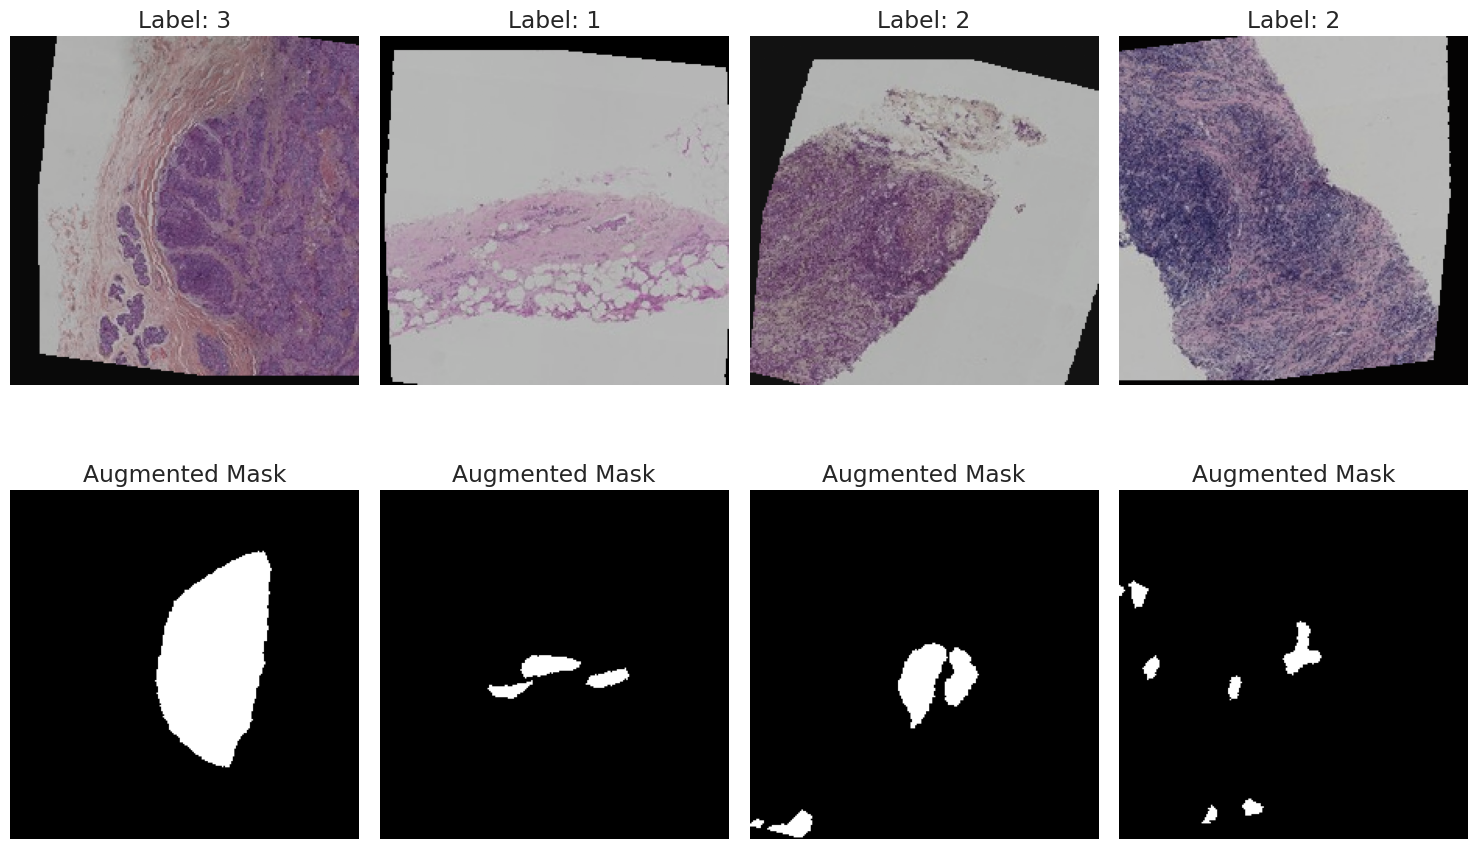

In [16]:
def show_batch(loader, count=4):
    # 1. Robust Unpacking
    # The loader might return 2 items (Image, Label) or 3 (Image, Label, Mask)
    batch = next(iter(loader))
    images, labels = batch[0], batch[1]
    masks = batch[2] if len(batch) > 2 else None

    # Determine layout: 1 row if no masks, 2 rows if masks exist
    nrows = 2 if masks is not None else 1
    plt.figure(figsize=(15, 5 * nrows))

    # Denormalize for visualization (ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(count):
        # --- Plot Image ---
        ax = plt.subplot(nrows, count, i + 1)
        
        img = images[i]
        img = img * std + mean  # Un-normalize
        img = torch.clamp(img, 0, 1)  # Clip to valid range
        
        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")

        # --- Plot Mask (if available) ---
        if masks is not None:
            ax = plt.subplot(nrows, count, i + 1 + count) # Second row
            mask = masks[i]
            # Mask is (1, H, W), squeeze to (H, W) for matplotlib
            plt.imshow(mask.squeeze(), cmap="gray")
            plt.title("Augmented Mask")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader)

## **8. Hyperparameters**

In [17]:
NUM_EPOCHS_TL = 200  
NUM_EPOCHS_FT = 200

PATIENCE = 20 




L2_REG = 1e-4
LR_TL = 1e-3
LR_FT = 1e-4

# --- Configuration ---
# How many blocks to unfreeze from the end of each backbone?
# 0 = Frozen, 1 = Last Block, 2 = Last 2 Blocks, etc.
UNFREEZE_LAYERS_IMG = 2  # For ResNet50 (The Color Stream)
UNFREEZE_LAYERS_MASK = 2  # For ResNet18 (The Geometry Stream)


## **9. Model Definition: Parallel - ResNet50 + ResNet18**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetParallel(nn.Module):
    def __init__(self, 
                 num_classes=4, 
                 freeze_backbone=False,
                 dropout_rate=0.3,):
        super(ResNetParallel, self).__init__()
        
        # --- Pillar 1: The Color Stream (RGB Image) ---
        # We use ResNet50 for the complex texture features
        img_resnet = models.resnet50(weights='DEFAULT')
        
        # Remove the Classification Head (fc) and avgpool
        # We want the spatial features or the flattened vector before the final layer
        # Here we take the layers up to the final pooling
        self.img_encoder = nn.Sequential(*list(img_resnet.children())[:-1])
        img_out_dim = 2048 # ResNet50 output size
        
        # --- Pillar 2: The Geometry Stream (Mask) ---
        # We use ResNet18 for the mask (shapes are simpler than textures)
        mask_resnet = models.resnet18(weights='DEFAULT')
        
        # MODIFY FIRST LAYER: ResNet expects 3 channels (RGB), Mask is 1 channel (Gray)
        # We sum the weights of the RGB channels to initialize the 1-channel weight
        original_conv1 = mask_resnet.conv1
        new_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            new_conv1.weight[:] = torch.sum(original_conv1.weight, dim=1, keepdim=True)
        mask_resnet.conv1 = new_conv1
        
        # Remove head
        self.mask_encoder = nn.Sequential(*list(mask_resnet.children())[:-1])
        mask_out_dim = 512 # ResNet18 output size
        
        # --- Freeze Logic (Optional) ---
        if freeze_backbone:
            for param in self.img_encoder.parameters():
                param.requires_grad = False
            for param in self.mask_encoder.parameters():
                param.requires_grad = False

        # --- The Summit: Fusion & Classification ---
        # We concatenate the two vectors: 2048 (Image) + 512 (Mask) = 2560
        fusion_dim = img_out_dim + mask_out_dim
        
        self.classifier = nn.Sequential(
            # Block 1: Compression & Non-Linearity
            nn.Linear(fusion_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),              # Modern activation (better than ReLU)
            nn.Dropout(p=dropout_rate+0.1),      # High dropout to force robust features
            
            # Block 2: Refinement
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            
            # Block 3: Final Decision
            nn.Linear(512, num_classes)
        )
    def _init_weights(self, module):
        for m in module.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, img, mask):
        # 1. Walk the Path of Color
        # img shape: [Batch, 3, 224, 224] -> [Batch, 2048, 1, 1]
        img_feat = self.img_encoder(img)
        img_feat = torch.flatten(img_feat, 1) # [Batch, 2048]
        
        # 2. Walk the Path of Geometry
        # mask shape: [Batch, 1, 224, 224] -> [Batch, 512, 1, 1]
        mask_feat = self.mask_encoder(mask)
        mask_feat = torch.flatten(mask_feat, 1) # [Batch, 512]
        
        # 3. The Fusion (Meet at the Summit)
        combined_feat = torch.cat((img_feat, mask_feat), dim=1) # [Batch, 2560]
        
        # 4. Final Decision
        logits = self.classifier(combined_feat)
        
        return logits
    
    def unfreeze(self):
        """Allow the pillars to adapt their foundations."""
        for param in self.img_encoder.parameters():
            param.requires_grad = True
        for param in self.mask_encoder.parameters():
            param.requires_grad = True

In [19]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_)
model = ResNetParallel(num_classes=num_classes,  freeze_backbone=True)
model = model.to(device)

print(f"Model initialized (ResNetParallel) with {num_classes} output classes.")
print_model_stats(model)


Both pillars are frozen. Only the summit (classifier) will learn.
Model initialized (ResNetParallel) with 4 output classes.
Total params: 37,830,660
Trainable params: 3,152,388


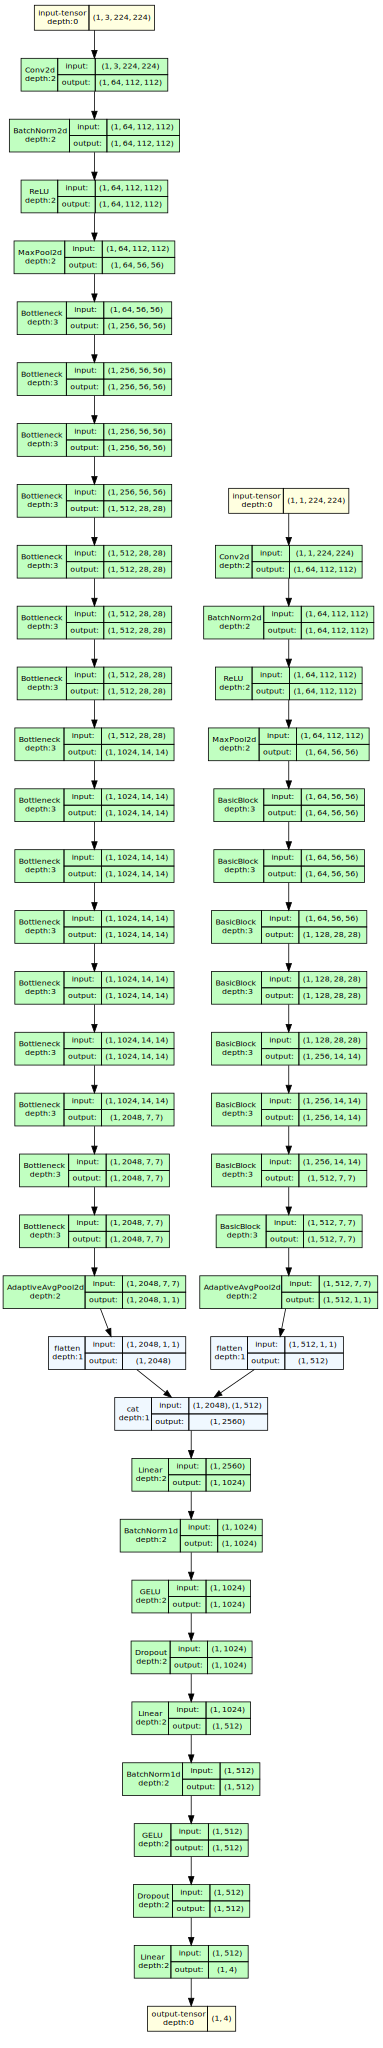

In [20]:
import torchsummary
model_graph = draw_graph(
    model, 
    input_size=[(1, 3, TARGET_SIZE[0], TARGET_SIZE[1]), (1, 1, TARGET_SIZE[0], TARGET_SIZE[1])],
    device=device.type
)
model_graph.visual_graph

## **10. Criterion and Optimizer**

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (Tensor, optional): Weights for each class. Shape [C].
            gamma (float): Focusing parameter. Higher value = more focus on hard examples.
                           Default is 2.0 (standard from the paper).
            reduction (str): 'mean', 'sum', or 'none'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: [Batch, C] (Logits)
        # targets: [Batch] (Class Indices)
        
        # 1. Standard Cross Entropy Loss (element-wise, no reduction yet)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # 2. Get the probability of the true class (pt)
        # pt = exp(-ce_loss) because ce_loss = -log(pt)
        pt = torch.exp(-ce_loss)
        
        # 3. Calculate Focal Component: (1 - pt)^gamma
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        # 4. Apply Class Weights (alpha) if provided
        if self.alpha is not None:
            # Gather the alpha value corresponding to the target class for each sample
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        # 5. Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [22]:
# 1. Get Counts (from your snippet)
class_counts = df_train['label_encoded'].value_counts().sort_index().values
total_samples = sum(class_counts)
n_classes = len(class_counts)

# 2. Define Manual Tuning Factors (The "weight" knob)
# 1.0 = Default (Pure Inverse Frequency)
# > 1.0 = Force model to focus MORE on this class (e.g., critical error)
# < 1.0 = Force model to focus LESS on this class (e.g., noisy label)
# Ensure this list length matches n_classes (4 in your case)
tuning_factors = torch.tensor([1.0, 1.0, 1.0, 0.6], dtype=torch.float32)

# 3. Calculate Base Weights (Standard Inverse Frequency)
# Formula: N / (C * freq)
base_weights = torch.tensor(
    [total_samples / (n_classes * c) for c in class_counts],
    dtype=torch.float32
)

# 4. Apply Tuning
# Final Weight = Inverse_Freq_Weight * Manual_Tuning_Factor
final_weights = base_weights * tuning_factors

# 5. Move to device
final_weights = final_weights.to(device)

print(f"Base Weights:  {base_weights}")
print(f"Tuning Factors:{tuning_factors}")
print(f"Final Weights: {final_weights}")

# --- DEFINING THE LOSS ---
# Gamma=2.0 is the standard starting point.
# If your model is still ignoring the minority class, try Gamma=3.0 or 4.0.
criterion_cls = FocalLoss(alpha=final_weights, gamma=2.0)

# Optimizer (remains the same)
optimizer = torch.optim.RAdam(
    [p for p in model.parameters() if p.requires_grad],
    lr=LR_TL,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=L2_REG
)

Base Weights:  tensor([0.8956, 0.8772, 0.7254, 2.7401])
Tuning Factors:tensor([1.0000, 1.0000, 1.0000, 0.6000])
Final Weights: tensor([0.8956, 0.8772, 0.7254, 1.6441], device='cuda:0')


## **11. Function: Training & Validation Loop**

In [23]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_metrics(preds, targets):
    # Move to CPU and convert to numpy
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    # Calculate Macro F1 (balanced for all classes)
    return f1_score(targets, preds, average='macro')

In [24]:
def train_one_epoch(model, loader, criterion_cls, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    loop = tqdm(loader, desc="Training", leave=False)
    
    for images, labels, masks in loop:
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # --- FIX 1: Pass BOTH Image and Mask ---
        # The model "fuses" them to produce a single classification result
        logits = model(images, masks) 
        
        # --- FIX 2: Classification Loss Only ---
        # We do not calculate segmentation loss because the mask is an INPUT here, not an output.
        loss = criterion_cls(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        
        loop.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

def validate(model, loader, criterion_cls, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels, masks in loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            
            # Pass both inputs
            logits = model(images, masks)
            
            # Loss
            loss = criterion_cls(logits, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(logits, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

## **OPTUNA**

### 1. Install Optuna

In [29]:
#%pip install optuna --quiet

### 2. Refactor Model Definition for Flexibility

In [37]:
def create_dynamic_model(trial, num_classes=4):
    """
    Dynamically builds the ResNetParallel model based on Optuna suggestions.
    """
    # Suggest Model Hyperparameters
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.6)
    dense_layer_size = trial.suggest_int("dense_layer_size", 512, 1024, step=128)
    
    model = ResNetParallel(num_classes=num_classes, freeze_backbone=True, dropout_rate=dropout_rate)
    
    # Overwrite the classifier part with dynamic sizes if needed
    # Note: Your original class hardcoded inputs to 2560 (2048+512). 
    # We keep that input fixed, but tune the hidden layers.
    fusion_dim = 2048 + 512
    
    model.classifier = nn.Sequential(
        nn.Linear(fusion_dim, dense_layer_size),
        nn.BatchNorm1d(dense_layer_size),
        nn.GELU(),
        nn.Dropout(p=dropout_rate + 0.1),
        
        nn.Linear(dense_layer_size, dense_layer_size // 2),
        nn.BatchNorm1d(dense_layer_size // 2),
        nn.GELU(),
        nn.Dropout(p=dropout_rate),
        
        nn.Linear(dense_layer_size // 2, num_classes)
    )
    # --- 3. Unfreeze parameters ---

    # A. Unfreeze the Classifier (Always unfreeze the summit)
    for param in model.classifier.parameters():
        param.requires_grad = True

    # B. Unfreeze Image Pillar (ResNet50)
    if UNFREEZE_LAYERS_IMG > 0:
        # Get the last N children (blocks)
        layers_to_train = list(model.img_encoder.children())[-UNFREEZE_LAYERS_IMG:]
        for block in layers_to_train:
            for param in block.parameters():
                param.requires_grad = True

    # C. Unfreeze Mask Pillar (ResNet18)
    if UNFREEZE_LAYERS_MASK > 0:
        layers_to_train = list(model.mask_encoder.children())[-UNFREEZE_LAYERS_MASK:]
        for block in layers_to_train:
            for param in block.parameters():
                param.requires_grad = True
    
    return model

### 3. Define the Objective Function
- This function runs one full "Trial". It initializes a model, picks parameters, runs a short training loop, and returns the validation F1 score.

In [38]:
import optuna
import torch.optim as optim
import gc

def objective(trial):
    # --- 1. Hyperparameter Search Space ---
    lr_tl = trial.suggest_float("lr_tl", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["RAdam", "AdamW", "SGD"])
    gamma_focal = trial.suggest_float("focal_gamma", 1.0, 5.0)
    
    # --- 2. Setup Resources ---
    # Clear memory from previous trials
    gc.collect()
    torch.cuda.empty_cache()
    
    # Initialize Model
    model = create_dynamic_model(trial, num_classes=len(label_encoder.classes_))
    model = model.to(device)
    
    # Define Loss with Dynamic Gamma
    # (Assuming 'final_weights' from your notebook is globally available)
    criterion = FocalLoss(alpha=None, gamma=gamma_focal)
    
    # Define Optimizer
    params_to_opt = [p for p in model.parameters() if p.requires_grad]
    if optimizer_name == "RAdam":
        optimizer = optim.RAdam(params_to_opt, lr=lr_tl, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(params_to_opt, lr=lr_tl, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(params_to_opt, lr=lr_tl, momentum=0.9, weight_decay=weight_decay)

    # --- 3. Short Training Loop ---
    # We run fewer epochs (e.g., 5) just to verify convergence speed/quality
    SEARCH_EPOCHS = 8
    
    for epoch in range(SEARCH_EPOCHS):
        # reuse your existing train_one_epoch
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # reuse your existing validate
        val_loss, val_f1 = validate(model, val_loader, criterion, device)
        
        # --- 4. Pruning ---
        # Report intermediate result to Optuna
        trial.report(val_f1, epoch)

        # Handle pruning (stop bad trials early)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the metric we want to MAXIMIZE
    return val_f1

### 4. Run the Optimization

In [39]:
# Create the study
study = optuna.create_study(
    direction="maximize", 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=2)
)

print("Starting Optuna Grid Search...")
# n_trials: Number of combinations to try
# timeout: Maximum seconds to run (e.g., 3600 for 1 hour)
study.optimize(objective, n_trials=20, timeout=None) 

# --- Display Results ---
print("\n" + "="*50)
print("Study Statistics")
print("="*50)
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best F1 Score: {study.best_value:.4f}")
print("Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-10 22:48:23,217] A new study created in memory with name: no-name-78df8a2e-75c3-427b-b1b5-126ac4ae885d


Starting Optuna Grid Search...
Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:50:06,807] Trial 0 finished with value: 0.36167872882027835 and parameters: {'lr_tl': 2.303037514004394e-05, 'weight_decay': 0.0006974733732975571, 'optimizer': 'AdamW', 'focal_gamma': 3.0673783788928293, 'dropout_rate': 0.37478839831974725, 'dense_layer_size': 768}. Best is trial 0 with value: 0.36167872882027835.


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:51:50,180] Trial 1 finished with value: 0.39556150818949454 and parameters: {'lr_tl': 0.0001550148117402285, 'weight_decay': 0.00020702990244791803, 'optimizer': 'AdamW', 'focal_gamma': 1.8620044248800025, 'dropout_rate': 0.4638894099801197, 'dense_layer_size': 768}. Best is trial 1 with value: 0.39556150818949454.


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:52:29,126] Trial 2 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:53:08,002] Trial 3 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:53:47,018] Trial 4 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:54:26,208] Trial 5 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:55:05,107] Trial 6 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:55:57,494] Trial 7 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:56:50,808] Trial 8 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:57:30,310] Trial 9 pruned.                          


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 22:59:14,617] Trial 10 finished with value: 0.3900910748471992 and parameters: {'lr_tl': 0.0008449389633466256, 'weight_decay': 2.189684596092949e-05, 'optimizer': 'AdamW', 'focal_gamma': 1.0357940860206876, 'dropout_rate': 0.5232520983140823, 'dense_layer_size': 896}. Best is trial 1 with value: 0.39556150818949454.


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:00:58,109] Trial 11 finished with value: 0.3805531160694889 and parameters: {'lr_tl': 0.0009336321585936397, 'weight_decay': 1.1871008997411294e-05, 'optimizer': 'AdamW', 'focal_gamma': 1.10546802557575, 'dropout_rate': 0.4904852424162268, 'dense_layer_size': 896}. Best is trial 1 with value: 0.39556150818949454.


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:01:50,689] Trial 12 pruned.                         


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:02:30,700] Trial 13 pruned.                         


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:03:10,103] Trial 14 pruned.                         


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:03:49,903] Trial 15 pruned.                         


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:04:29,498] Trial 16 pruned.                         


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:05:09,091] Trial 17 pruned.                         


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:05:48,833] Trial 18 pruned.                         


Both pillars are frozen. Only the summit (classifier) will learn.


[I 2025-12-10 23:06:28,296] Trial 19 pruned.                         



Study Statistics
Number of finished trials: 20
Best F1 Score: 0.3956
Best Hyperparameters:
  lr_tl: 0.0001550148117402285
  weight_decay: 0.00020702990244791803
  optimizer: AdamW
  focal_gamma: 1.8620044248800025
  dropout_rate: 0.4638894099801197
  dense_layer_size: 768


### 5. Visualization

In [47]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate


# 1. History (Did it improve over time?)
fig1 = plot_optimization_history(study)
fig1.show()

# 2. Importance (Which parameter affects the F1 score the most?)
fig2 = plot_param_importances(study)
fig2.show()

# 3. Parallel Coordinate (How do parameters interact?)
fig3 = plot_parallel_coordinate(study)
fig3.show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

## **12. Training Loop: Transfer Learning**

### 12.1 Training

In [ ]:

# --- Training Variables ---
best_val_f1 = 0.0
best_val_loss = float('inf')
patience_counter = 0
best_tl_epoch = 0
model_saved = False

history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

print(f"Starting Training with ResNetParallel (Auxiliary Attention) (Patience: {PATIENCE})...")

for epoch in range(NUM_EPOCHS_TL):
    # Train
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion_cls, optimizer, device, )

    # Validate
    val_loss, val_f1 = validate(model, val_loader, criterion_cls, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset counter
        best_tl_epoch = epoch + 1
        torch.save(model.state_dict(), 'models/best_model_ResNetParallel_tl.pt')
        model_saved = True
    else:
        model_saved = False
        patience_counter += 1

    # Print matching your requested format
    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS_TL} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE} Best:{best_val_f1:.4f} ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS_TL} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("   >>> Early Stopping Triggered! Training stopped.")
        break
    
SUB_MODEL = 'models/best_model_ResNetParallel_tl.pt'
print(f"Submodel saved to {SUB_MODEL} at epoch {best_tl_epoch} with Val F1: {best_val_f1:.4f} for now. Will update if better model found in fine tuning.")

Starting Training with ResNetParallel (Auxiliary Attention) (Patience: 20)...


TL Epoch 1/200 | Loss: 0.7758 | F1: 0.2500 | Val Loss: 0.7338 | Val F1: 0.2874 | Patience: 0/20 Best:0.2874 ✓


TL Epoch 2/200 | Loss: 0.6861 | F1: 0.3267 | Val Loss: 0.6991 | Val F1: 0.3413 | Patience: 0/20 Best:0.3413 ✓


TL Epoch 3/200 | Loss: 0.6351 | F1: 0.4066 | Val Loss: 0.7025 | Val F1: 0.3566 | Patience: 0/20 Best:0.3566 ✓


TL Epoch 4/200 | Loss: 0.5774 | F1: 0.4389 | Val Loss: 0.7249 | Val F1: 0.3377 | Patience: 1/20


TL Epoch 5/200 | Loss: 0.5495 | F1: 0.4743 | Val Loss: 0.6959 | Val F1: 0.3763 | Patience: 0/20 Best:0.3763 ✓


TL Epoch 6/200 | Loss: 0.5260 | F1: 0.4754 | Val Loss: 0.7208 | Val F1: 0.3799 | Patience: 0/20 Best:0.3799 ✓


TL Epoch 7/200 | Loss: 0.5213 | F1: 0.4964 | Val Loss: 0.7301 | Val F1: 0.3436 | Patience: 1/20


TL Epoch 8/200 | Loss: 0.5132 | F1: 0.5134 | Val Loss: 0.7285 | Val F1: 0.3956 | Patience: 0/20 Best:0.3956 ✓


TL Epoch 9/200 | Loss: 0.4712 | F1: 0.5401 | Val Loss: 0.7451 | Val F1: 0.3842 | Patience: 1/20


TL Epoch 10/200 | Loss: 0.4815 | F1: 0.5461 | Val Loss: 0.7294 | Val F1: 0.3761 | Patience: 2/20


TL Epoch 11/200 | Loss: 0.4562 | F1: 0.5514 | Val Loss: 0.7056 | Val F1: 0.3948 | Patience: 3/20


TL Epoch 12/200 | Loss: 0.4254 | F1: 0.5821 | Val Loss: 0.7116 | Val F1: 0.3795 | Patience: 4/20


TL Epoch 13/200 | Loss: 0.4349 | F1: 0.5774 | Val Loss: 0.7323 | Val F1: 0.3830 | Patience: 5/20


TL Epoch 14/200 | Loss: 0.4180 | F1: 0.5750 | Val Loss: 0.7321 | Val F1: 0.3693 | Patience: 6/20


TL Epoch 15/200 | Loss: 0.4216 | F1: 0.5866 | Val Loss: 0.7334 | Val F1: 0.3982 | Patience: 0/20 Best:0.3982 ✓


Training:   0%|          | 0/35 [00:00<?, ?it/s]

### 12.2 Training History

In [ ]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.plot(history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))

### 12.4 Confusion Matrix

In [ ]:

# 3. Calculate and Plot Confusion Matrix
print("Generating Confusion Matrix on Original Images...")
y_true_img, y_pred_img = get_image_predictions(model, val_loader, device)

# Compute Matrix
cm = confusion_matrix(y_true_img, y_pred_img)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated per Image)')
plt.show()


In [ ]:
# Visualize a random validation sample
print("Plotting random validation sample with prediction distribution:")
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence')

## **13. Training Loop: Fine Tuning**

### 13.1 Training

In [ ]:
# --- FINE-TUNING PHASE SETUP ---
ft_model = ResNetParallel(num_classes=num_classes, freeze_backbone=True).to(device)

# --- 2. Load the best weights from the first phase ---
ft_model.load_state_dict(torch.load("models/best_model_ResNetParallel_tl.pt"), strict=True)

print(f"Fine-Tuning Configuration:")
print(f" - Image Pillar (ResNet50): Unfreezing last {UNFREEZE_LAYERS_IMG} blocks")
print(f" - Mask Pillar (ResNet18): Unfreezing last {UNFREEZE_LAYERS_MASK} blocks")

# --- 3. Unfreeze parameters ---

# A. Unfreeze the Classifier (Always unfreeze the summit)
for param in ft_model.classifier.parameters():
    param.requires_grad = True

# B. Unfreeze Image Pillar (ResNet50)
if UNFREEZE_LAYERS_IMG > 0:
    # Get the last N children (blocks)
    layers_to_train = list(ft_model.img_encoder.children())[-UNFREEZE_LAYERS_IMG:]
    for block in layers_to_train:
        for param in block.parameters():
            param.requires_grad = True
            
# C. Unfreeze Mask Pillar (ResNet18)
if UNFREEZE_LAYERS_MASK > 0:
    layers_to_train = list(ft_model.mask_encoder.children())[-UNFREEZE_LAYERS_MASK:]
    for block in layers_to_train:
        for param in block.parameters():
            param.requires_grad = True

# --- 4. Optimizer ---
ft_optimizer = torch.optim.RAdam(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=LR_FT, 
    weight_decay=L2_REG
)
# --- 5. Scheduler ---
ft_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ft_optimizer, mode='min', factor=0.1, patience=3, 
)


In [ ]:
print_model_stats(ft_model)

In [ ]:

print("Starting Fine-Tuning Phase...")

# Reset history
ft_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_val_f1_ft = 0.0
patience_counter_ft = 0
best_ft_epoch = 0
model_saved = False
ft_better_than_tl = False

# --- 6. Fine-Tuning Loop ---
for epoch in range(NUM_EPOCHS_FT):
    # Train (Pass BOTH criteria)
    train_loss, train_f1 = train_one_epoch(ft_model, train_loader, criterion_cls , ft_optimizer, device)

    # Validate (Pass BOTH criteria)
    val_loss, val_f1 = validate(ft_model, val_loader, criterion_cls, device)

    # Update Scheduler based on Validation Loss
    ft_scheduler.step(val_loss)

    # Store history
    ft_history['train_loss'].append(train_loss)
    ft_history['train_f1'].append(train_f1)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_f1'].append(val_f1)

    # --- Checkpointing & Early Stopping ---
    if val_f1 > best_val_f1_ft:
        best_val_f1_ft = val_f1
        best_ft_epoch = epoch + 1
        patience_counter_ft = 0 
        
        # Save the fine-tuned model
        torch.save(ft_model.state_dict(), 'models/best_model_ResNetParallel_ft.pt')
        model_saved = True
        
        # Check if we beat the Transfer Learning phase
        if best_val_f1_ft > best_val_f1:
            ft_better_than_tl = True
    else:
        model_saved = False
        patience_counter_ft += 1

    # Print Status
    status_mark = "✓" if model_saved else ""
    print(f"FT Epoch {epoch+1}/{NUM_EPOCHS_FT} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE} {status_mark}")

    if patience_counter_ft >= PATIENCE:
        print(f"\nEarly Stopping Triggered! Best FT Epoch: {best_ft_epoch} with Val F1: {best_val_f1_ft:.4f}")
        break

# Final Summary
SUB_MODEL = 'models/best_model_ResNetParallel_ft.pt' if ft_better_than_tl else 'models/best_model_ResNetParallel_tl.pt'
print(f"\nFine-Tuning Complete.")
print(f"Best TL F1: {best_val_f1:.4f}")
print(f"Best FT F1: {best_val_f1_ft:.4f}")
print(f"Best Model Saved to: {SUB_MODEL}")

### 13.2 Training History

In [ ]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(ft_history['train_loss'], label='Train Loss')
plt.plot(ft_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(ft_history['train_f1'], label='Train F1 (Macro)')
plt.plot(ft_history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Fine-Tuned Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_ft_epoch))

### 13.3 Confusion Matrix

In [ ]:

# 1. Get predictions for the Transfer Learning model (from original `model`)
print("Generating Confusion Matrix for Transfer Learning Model...")
y_true_tl, y_pred_tl = get_image_predictions(model, val_loader, device)
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

# 2. Get predictions for the Fine-Tuning model (from `ft_model`)
print("Generating Confusion Matrix for Fine-Tuning Model...")
y_true_ft, y_pred_ft = get_image_predictions(ft_model, val_loader, device)
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

# 3. Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot Transfer Learning Confusion Matrix
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (Transfer Learning)')

# Plot Fine-Tuning Confusion Matrix
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Fine-Tuning)')

plt.tight_layout()
plt.show()


In [ ]:
# Visualize a random validation sample
print("Transfer Learning:")
sample_id_plot = np.random.choice(val_loader.dataset.df['sample_id'].unique())
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)
print("Fine Tuning:")
plot_sample_with_predictions(ft_model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)

## **14. Class Activation Maps**

### **14.1 Cam Helper Functions**

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision import transforms
from PIL import Image
import os

# --- 1. Grad-CAM Helper Class (Updated for Two-Stream) ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        self.handle_fwd = self.target_layer.register_forward_hook(self.save_activation)
        self.handle_bwd = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, mask, class_idx=None):
        # 1. Forward pass (Pass BOTH inputs)
        # Two-Stream model returns ONLY logits.
        output = self.model(x, mask)
        
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # 2. Backward pass
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        
        # 3. Generate CAM
        gradients = self.gradients
        activations = self.activations
        
        if gradients is None or activations is None:
            raise RuntimeError("Hooks failed. Ensure target_layer is visited.")

        b, k, u, v = gradients.size()
        
        # Global Average Pooling
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        
        # Linear combination
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam) 
        
        # 4. Upsample to image size
        cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        # 5. Normalize
        cam = cam.view(1, -1)
        cam -= cam.min()
        cam /= (cam.max() + 1e-7)
        cam = cam.view(1, 1, x.shape[2], x.shape[3])
        
        return cam.detach().cpu().numpy()[0, 0], output

    def remove_hooks(self):
        self.handle_fwd.remove()
        self.handle_bwd.remove()

# --- 2. Mask Overlay Function ---
def get_mask_overlay(cam_mask, patch_path, masks_dir, img_fallback=None, alpha=0.6):
    """Overlays CAM onto the ground truth mask."""
    bg_img = None
    mask_found = False

    if masks_dir:
        # Robust filename logic
        filename = os.path.basename(patch_path)
        mask_filename = filename.replace('img_', 'mask_')
        mask_path = os.path.join(masks_dir, mask_filename)

        if os.path.exists(mask_path):
            try:
                mask_pil = Image.open(mask_path).convert('L') 
                mask_pil = mask_pil.resize((224, 224))
                mask_np = np.array(mask_pil)
                mask_display = mask_np.astype(np.float32) / 255.0 
                bg_img = np.stack([mask_display]*3, axis=-1)
                mask_found = True
            except Exception as e:
                pass

    # Fallback
    if bg_img is None:
        bg_img = img_fallback if img_fallback is not None else np.zeros((224, 224, 3), dtype=np.float32)

    # Heatmap
    heatmap = cv2.resize(cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255

    overlay = (alpha * heatmap_colored) + ((1 - alpha) * bg_img)
    overlay = overlay / np.max(overlay) 
    
    return overlay, mask_found

# --- 3. Main Visualization Function (Two-Stream Updated) ---
def visualize_sample_analysis(model, df_metadata, sample_id, label_encoder, device, masks_dir=None):
    """
    Visualizes analysis for a sample using the Two-Stream Model.
    Args:
        model: The trained Two-Stream model.
        df_metadata: The pandas DataFrame containing image paths and labels.
        sample_id: The ID of the sample to visualize.
        label_encoder: The encoder used for labels.
        device: 'cuda' or 'cpu'.
        masks_dir: (Optional) Path to the masks folder.
    """
    model.eval()
    
    # --- 1. Filter DataFrame directly ---
    sample_rows = df_metadata[df_metadata['sample_id'] == sample_id]
    
    if len(sample_rows) == 0:
        print(f"Sample {sample_id} not found in the provided DataFrame.")
        return

    # --- 2. Define Transforms ---
    img_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])

    # --- 3. Batch Inference ---
    patch_probs = []
    patch_data = [] 
    
    # Target Layer Selection
    try:
        # Try to grab the last bottleneck block of the image encoder
        target_layer = model.img_encoder[-2][-1] 
    except:
        # Fallback
        target_layer = list(model.img_encoder.children())[-2]

    grad_cam = GradCAM(model, target_layer)
    
    print(f"Processing sample {sample_id} with {len(sample_rows)} patches...")
    
    for _, row in sample_rows.iterrows():
        try:
            # Load Image
            img_pil = Image.open(row['path']).convert('RGB')
            img_tensor = img_transform(img_pil).unsqueeze(0).to(device)
            
            # Load Mask
            mask_pil = Image.new('L', (224, 224), 0)
            if masks_dir:
                fname = os.path.basename(row['path'])
                mname = fname.replace('img_', 'mask_')
                mpath = os.path.join(masks_dir, mname)
                if os.path.exists(mpath):
                    mask_pil = Image.open(mpath).convert('L')
            
            mask_tensor = mask_transform(mask_pil).unsqueeze(0).to(device)
            
            patch_data.append({
                'img_tensor': img_tensor, 
                'mask_tensor': mask_tensor, 
                'path': row['path']
            })
            
            with torch.no_grad():
                outputs = model(img_tensor, mask_tensor)
                probs = F.softmax(outputs, dim=1)
                patch_probs.append(probs.cpu().numpy())
                
        except Exception as e:
            # print(f"Skipping patch: {e}")
            continue

    if not patch_probs:
        print("No valid patches found.")
        grad_cam.remove_hooks()
        return

    patch_probs = np.vstack(patch_probs)
    avg_probs = np.mean(patch_probs, axis=0) 
    
    classes = label_encoder.classes_
    pred_class_idx = np.argmax(avg_probs)
    pred_label = classes[pred_class_idx]
    
    # Get True Label
    if 'label_encoded' in sample_rows.columns:
        true_label_idx = sample_rows.iloc[0]['label_encoded']
        true_label = label_encoder.inverse_transform([true_label_idx])[0]
    else:
        true_label = "Unknown"
    
    # --- 4. Select Best Patch ---
    best_patch_idx = np.argmax(patch_probs[:, pred_class_idx])
    best_data = patch_data[best_patch_idx]
    
    # Prepare active tensors for GradCAM
    img_tensor_active = best_data['img_tensor'].clone().detach()
    mask_tensor_active = best_data['mask_tensor'].clone().detach()
    img_tensor_active.requires_grad = True 
    patch_path = best_data['path']

    # --- 5. Generate GradCAM ---
    # A. Predicted Class CAM
    pred_cam_mask, _ = grad_cam(img_tensor_active, mask_tensor_active, pred_class_idx)
    
    # Display Image (Denormalized)
    img_display = inv_normalize(best_data['img_tensor'][0]).cpu().detach().numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)
    
    # Overlay on Image
    heatmap = cv2.resize(pred_cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255
    cam_on_image = (0.5 * heatmap_colored) + (0.5 * img_display)
    cam_on_image = cam_on_image / np.max(cam_on_image)
    
    # Overlay on Mask
    cam_on_mask_main, mask_found_main = get_mask_overlay(
        pred_cam_mask, patch_path, masks_dir, img_fallback=img_display
    )

    # B. Other Classes CAMs
    other_indices = [i for i in range(len(classes)) if i != pred_class_idx]
    cam_others_data = {}
    
    for i in other_indices:
        img_tensor_active.grad = None 
        mask_map, _ = grad_cam(img_tensor_active, mask_tensor_active, i)
        
        overlay, is_mask = get_mask_overlay(
            mask_map, patch_path, masks_dir, img_fallback=img_display
        )
        cam_others_data[i] = (overlay, is_mask)
        
    grad_cam.remove_hooks() 

    # --- 6. Plotting ---
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, max(4, len(other_indices)), height_ratios=[1.2, 0.8])

    # Row 1
    # 1. Original
    ax0 = plt.subplot(gs[0, 0])
    ax0.imshow(img_display)
    ax0.set_title(f"Best Patch\nTrue: {true_label}", fontsize=12, fontweight='bold')
    ax0.axis('off')

    # 2. Predicted CAM on Image
    ax1 = plt.subplot(gs[0, 1])
    ax1.imshow(cam_on_image)
    ax1.set_title(f"Focus (Img): {pred_label}\n({avg_probs[pred_class_idx]:.1%})", fontsize=12, fontweight='bold', color='darkblue')
    ax1.axis('off')
    
    # 3. Predicted CAM on Mask
    ax2 = plt.subplot(gs[0, 2])
    if mask_found_main:
        ax2.imshow(cam_on_mask_main)
        ax2.set_title(f"Focus (Mask): {pred_label}", fontsize=12, fontweight='bold')
        ax2.axis('off')
    else:
        ax2.text(0.5, 0.5, "Mask Not Found\n(Using Image BG)", ha='center')
        ax2.imshow(cam_on_mask_main) # Show overlay on fallback image
        ax2.axis('off')

    # 4. Stats
    ax3 = plt.subplot(gs[0, 3])
    colors = ['#d3d3d3'] * len(classes)
    colors[pred_class_idx] = '#4CAF50' if pred_label == true_label else '#F44336'
    
    bars = ax3.bar(classes, avg_probs, color=colors, alpha=0.85, edgecolor='black')
    ax3.set_title(f"Sample ID: {sample_id}", fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.05)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    # Row 2: Other Classes
    if not other_indices:
        # Handle binary case where there are no "other" classes if we only plot top 1 vs others
        pass
    else:
        for idx, class_idx in enumerate(other_indices):
            ax = plt.subplot(gs[1, idx])
            overlay, is_mask = cam_others_data[class_idx]
            
            ax.imshow(overlay)
            class_name = classes[class_idx]
            ax.set_title(f"{class_name}\n({avg_probs[class_idx]:.1%})", fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

### **14.2 CAM Visualization**

In [ ]:
# Select a sample ID from your validation set
if SUB_MODEL is None:
    SUB_MODEL = 'models/best_model_ResNetMTL_tl.pt'  # Default to TL model if none specified
PATCH_MASKS_DIR = os.path.join(datasets_path, "preprocessing_results","train_patches","masks")
cam_model = ResNetParallel(num_classes, freeze_backbone=True).to(device)
cam_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
cam_idx = random.randint(0, len(df_val['sample_id'].unique()) - 1)
sample_id_to_test = df_val['sample_id'].iloc[cam_idx] 
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device)
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device, masks_dir=PATCH_MASKS_DIR)

## **14. Submission Creation**

### 14.1 Create Submission Model

In [ ]:
sub_model = ResNetParallel(num_classes, freeze_backbone=True).to(device)

# 2. Load the best weights from the training
sub_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
print(f"Submodel loaded from {SUB_MODEL} for final evaluation.")


### 14.2 Define Transform

In [ ]:
# Define Validation Transform (Compatible with V2 or Standard)
val_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(), # Robust standard equivalent to ToImage + ToDtype
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


### 14.3 Function: Submission CSV

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

def generate_submission(model, submission_folder, masks_folder=None, method='max_confidence', output_csv="submission.csv"):
    """
    Generates a submission file for the Two-Stream (Two Pillar) model.
    Args:
        model: Trained TwoStream/ResNetParallel model.
        submission_folder: Folder containing test patch images.
        masks_folder: (Optional) Folder containing corresponding masks. 
                      If None, tries to find them or uses black masks.
    """
    model.eval()

    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(patch_files)} patches in {submission_folder}")
    if masks_folder:
        print(f"Looking for masks in: {masks_folder}")
    else:
        print("No mask folder provided. Using black masks (or inferred paths).")

    # 2. Define Transforms
    # Image: Normalize
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Mask: No Normalize
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Store predictions per image
    image_predictions = {}

    print("Running inference...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)

            try:
                # Extract Sample ID
                if '_p' in filename:
                    sample_id = filename.rsplit('_p', 1)[0]
                else:
                    sample_id = os.path.splitext(filename)[0]

                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # --- A. Load Image ---
                image = Image.open(filepath).convert('RGB')
                input_tensor = val_transform(image).unsqueeze(0).to(device)

                # --- B. Load Mask ---
                # Default: Black mask
                mask_pil = Image.new('L', (224, 224), 0)
                
                if masks_folder:
                    # Construct mask filename (e.g., img_X.png -> mask_X.png)
                    mask_filename = filename.replace('img_', 'mask_')
                    mask_path = os.path.join(masks_folder, mask_filename)
                    
                    if os.path.exists(mask_path):
                        mask_pil = Image.open(mask_path).convert('L')
                
                mask_tensor = mask_transform(mask_pil).unsqueeze(0).to(device)

                # --- C. Model Inference (Two Pillars) ---
                # Pass BOTH tensors
                logits = model(input_tensor, mask_tensor)
                
                # Softmax to get probabilities
                probs = torch.softmax(logits, dim=1)

                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])

            except Exception as e:
                # print(f"Error processing {filename}: {e}")
                pass

    # 3. Aggregate Results
    final_results = []

    print(f"Aggregating results for {len(image_predictions)} unique samples...")

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) 

        # Reconstruct full filename for submission (e.g. img_0015.png)
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) 
            continue

        if method == 'majority_voting':
            patch_preds = np.argmax(all_probs, axis=1)
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)

        elif method == 'max_confidence':
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)

        # Decode Label
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Save
    df_submission = pd.DataFrame(final_results)
    
    if 'sample_index' in df_submission.columns:
        df_submission.sort_values('sample_index', inplace=True)
    
    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")
    # print(df_submission.head())

    return df_submission

### 14.3 Create the Submission CSV

In [ ]:
now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
OUTPUT_NAME = os.path.join(sub_dir, f"submission_ft--{date_time_str}.csv")


os.makedirs(sub_dir, exist_ok=True)

# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, SUBMISSION_PATCH_MASKS, method='max_confidence', output_csv=OUTPUT_NAME)
    print(f"Submission CSV saved to: {OUTPUT_NAME}")

    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")